## 0 Setup
These are the same packages as in the last exercise:

In [1]:
!pip install torch torchvision torchaudio
!pip install gymnasium==0.29.1
!pip install minatar==1.0.15
!pip install matplotlib
!pip install imageio

In [2]:
# Imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import numpy as np
import pandas as pd
from PIL import Image
import gymnasium as gym
import matplotlib.pyplot as plt
from collections import namedtuple
import itertools

import torch
import random

from DQN import DQN
from utils import make_epsilon_greedy_policy, linear_epsilon_decay

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
import random
import heapq
import torch
import torch.nn.functional as F

class PrioritizedReplayBufferHeap:
    def __init__(self, max_size: int, alpha: float = 0.2, beta: float = 0.4):
        self.max_size = max_size
        self.alpha = alpha
        self.beta = beta
        self.pointer = 0
        self.size = 0
        self.max_priority = 1.0
        
        # Experience buffer
        self.buffer = [None] * max_size
        
        # Min-heap for storing (priority, index) tuples
        self.priority_heap = []
    
    def __len__(self):
        return self.size

    def store(self, obs, action, reward, next_obs, terminated):
        idx = self.pointer
        transition = (obs, action, reward, next_obs, terminated)
        self.buffer[idx] = transition
        
        # Assign priority to new transition
        priority = self.max_priority ** self.alpha
        heapq.heappush(self.priority_heap, (priority, idx))
        
        self.pointer = (self.pointer + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)
    
    def update_priorities(self, indices, priorities):
        for idx, priority in zip(indices, priorities):
            new_priority = priority ** self.alpha
            heapq.heappush(self.priority_heap, (new_priority, idx))
            self.max_priority = max(self.max_priority, new_priority)
    
    def _sample_indices(self, batch_size):
        """Sample indices based on softmax priority from a subset of 1000 randomly chosen elements."""
        sample_size = min(1000, len(self))  # Ensure we don't sample more than available elements
        subset = random.sample(self.priority_heap[-len(self):], sample_size)  # Randomly sample 1k elements

        priorities, indices = zip(*subset)  # Extract priorities and indices
        priorities = torch.tensor(priorities, dtype=torch.float32)

        # Compute softmax probabilities
        probs = F.softmax(priorities, dim=0).numpy()
        sampled_indices = random.choices(indices, weights=probs, k=batch_size)

        return sampled_indices, priorities, probs
    
    def _compute_importance_weights(self, indices, priorities, probs):
        """Calculate importance-sampling weights."""
        p_min = min(priorities) / sum(priorities)
        max_weight = (p_min * len(self)) ** -self.beta
        weights = ((torch.tensor(probs[:len(indices)]) * len(self)) ** -self.beta) / max_weight
        return weights
    
    def sample(self, batch_size, beta):
        assert len(self) >= batch_size
        
        indices, priorities, probs = self._sample_indices(batch_size)
        weights = self._compute_importance_weights(indices, priorities, probs)
        transitions = [self.buffer[idx] for idx in indices]
        obs, actions, rewards, next_obs, terminated = zip(*transitions)
        
        obs = torch.stack([o.clone().detach() for o in obs])
        actions = torch.tensor(actions)
        rewards = torch.tensor(rewards)
        next_obs = torch.stack([no.clone().detach() for no in next_obs])
        terminated = torch.tensor(terminated)
        weights = torch.tensor(weights)
        
        return obs, actions, rewards, next_obs, terminated, indices, weights


In [4]:
def update_dqn(
        q: nn.Module,
        q_target: nn.Module,
        optimizer: optim.Optimizer,
        gamma: float,
        obs: torch.Tensor,
        act: torch.Tensor,
        rew: torch.Tensor,
        next_obs: torch.Tensor,
        tm: torch.Tensor,
        indices: list,
        weights: torch.Tensor,
        memory: PrioritizedReplayBuffer,
        priority_eps: float = 1e-6,
    ):
    """
    Update the DDQN network for one optimizer step.

    :param q: The DQN network.
    :param q_target: The target DQN network.
    :param optimizer: The optimizer.
    :param gamma: The discount factor.
    :param obs: Batch of current observations.
    :param act: Batch of actions.
    :param rew: Batch of rewards.
    :param next_obs: Batch of next observations.
    :param tm: Batch of termination flags.
    """

    with torch.no_grad():
        # Use q (main network) to select the action
        next_q_values = q(next_obs)
        best_actions = torch.argmax(next_q_values, dim=1, keepdim=True)

        # Use q_target (target network) to evaluate the action
        q_target_values = q_target(next_obs)
        max_q_s_prime = torch.gather(q_target_values, dim=1, index=best_actions).squeeze(1)

        # Compute TD target
        td_target = rew + gamma * max_q_s_prime * ~tm

    # Compute current Q-values
    q_s_a = torch.gather(q(obs), dim=1, index=act.unsqueeze(1)).squeeze(1)
    elementwise_loss = F.smooth_l1_loss(q_s_a, td_target, reduction="none")

    # Apply importance sampling weights
    loss = torch.mean(elementwise_loss * weights)

    # Backpropagate and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Update priorities in memory
    td_delta = elementwise_loss.detach().cpu().numpy()
    new_priorities = td_delta + priority_eps
    memory.update_priorities(indices, new_priorities)

    return loss.item()


In [5]:
EpisodeStats = namedtuple("Stats", ["episode_lengths", "episode_rewards"])

class DQNAgent:
    def __init__(self,
            env,
            gamma=0.99,
            lr=0.001, 
            batch_size=64,
            eps_start=1.0,
            eps_end=0.1,
            schedule_duration=10_000,
            update_freq=100,
            maxlen=100_000,
            alpha=0.2,
            beta=0.6,
            squared_grad_momentum=0.95,
            min_squared_grad=0.01
        ):
        """
        Initialize the DQN agent.

        :param env: The environment.
        :param gamma: The discount factor.
        :param lr: The learning rate.
        :param batch_size: Mini batch size.
        :param eps_start: The initial epsilon value.
        :param eps_end: The final epsilon value.
        :param schedule_duration: The duration of the schedule (in timesteps).
        :param update_freq: How often to update the Q target.
        :param max_size: Maximum number of transitions in the buffer.
        """

        self.env = env
        self.gamma = gamma
        self.batch_size = batch_size
        self.eps_start = eps_start
        self.eps_end = eps_end
        self.schedule_duration = schedule_duration
        self.update_freq = update_freq
        self.beta = beta
        self.device=DEVICE

        # Initialize the Replay Buffer
        self.replay_buffer = PrioritizedReplayBuffer(maxlen, alpha)

        # Initialize the Deep Q-Network. Hint: Remember observation_space and action_space
        self.q = DQN(self.env.observation_space.shape, self.env.action_space.n)
        self.q.to(self.device)

        # Initialize the second Q-Network, the target network. Load the parameters of the first one into the second
        self.q_target = DQN(self.env.observation_space.shape, self.env.action_space.n)
        self.q_target.load_state_dict(self.q.state_dict())
        self.q_target.to(self.device)

        # Create an ADAM optimizer for the Q-network
        self.optimizer = optim.RMSprop(self.q.parameters(), lr=lr, alpha=squared_grad_momentum, centered=True, eps=min_squared_grad)

        self.policy = make_epsilon_greedy_policy(self.q, env.action_space.n)


    def train(self, num_episodes: int) -> EpisodeStats:
        """
        Train the DQN agent.

        :param num_episodes: Number of episodes to train.
        :returns: The episode statistics.
        """
        # Keeps track of useful statistics
        stats = EpisodeStats(
            episode_lengths=np.zeros(num_episodes),
            episode_rewards=np.zeros(num_episodes),
        )
        current_timestep = 0
        epsilon = self.eps_start

        for i_episode in range(num_episodes):
            # Print out which episode we're on, useful for debugging.
            if (i_episode + 1) % 100 == 0:
                print(f'Episode {i_episode + 1} of {num_episodes}  Time Step: {current_timestep}  Epsilon: {epsilon:.3f}')

            # Reset the environment and get initial observation
            obs, _ = self.env.reset()
            
            for episode_time in itertools.count():
                # Get current epsilon value
                epsilon = linear_epsilon_decay(self.eps_start, self.eps_end, current_timestep, self.schedule_duration)

                # Choose action and execute
                obs = torch.as_tensor(obs).to(self.device)
                action = self.policy(obs.unsqueeze(0).float(), epsilon=epsilon)
                next_obs, reward, terminated, truncated, _ = self.env.step(action)

                # Update statistics
                stats.episode_rewards[i_episode] += reward
                stats.episode_lengths[i_episode] += 1

                # Store sample in the replay buffer
                self.replay_buffer.store(torch.tensor(obs),
                                         torch.tensor(action),
                                         torch.tensor(reward),
                                         torch.tensor(next_obs),
                                         torch.tensor(terminated))
                
                # Linearly increase beta 
                fraction = min(i_episode / num_episodes, 1.0)
                self.beta = self.beta + fraction * (1.0 - self.beta)

                # Sample a mini batch from the replay buffer
                
                if len(self.replay_buffer) > self.batch_size:
                    obs_batch, act_batch, rew_batch, next_obs_batch, tm_batch, indices, weights = self.replay_buffer.sample(self.batch_size, self.beta)
                    obs_batch = obs_batch.to(self.device)
                    act_batch = act_batch.to(self.device)
                    rew_batch = rew_batch.to(self.device)
                    next_obs_batch = next_obs_batch.to(self.device)
                    tm_batch = tm_batch.to(self.device)
                    weights = weights.to(self.device)

                    # Update the Q network
                    update_dqn(
                        self.q,
                        self.q_target,
                        self.optimizer,
                        self.gamma, 
                        obs_batch.float(),
                        act_batch, 
                        rew_batch.float(),
                        next_obs_batch.float(),
                        tm_batch,
                        indices,
                        weights,
                        self.replay_buffer
                    )

                    # Update the current Q target
                    if current_timestep % self.update_freq == 0:
                        self.q_target.load_state_dict(self.q.state_dict())
                    current_timestep += 1

                # Check whether the episode is finished
                if terminated or truncated or episode_time >= 500:
                    break
                obs = next_obs
        return stats


In [6]:
# Choose your environment
env = gym.make('MinAtar/Asterix-v1', render_mode="rgb_array")

# Print observation and action space infos
print(f"Training on {env.spec.id}")
print(f"Observation space: {env.observation_space}")
print(f"Action space: {env.action_space}\n")

# Hyperparameters, Hint: Change as you see fit
LR = 0.001
BATCH_SIZE = 64
REPLAY_BUFFER_SIZE = 100_000
UPDATE_FREQ = 100
EPS_START = 1
EPS_END = 0.1
SCHEDULE_DURATION = 15_000
NUM_EPISODES = 1_000

ALPHA = 0.6
BETA = 0.4
DISCOUNT_FACTOR = 0.99

# Train DQN
agent = DQNAgent(
    env, 
    gamma=DISCOUNT_FACTOR,
    lr=LR,
    batch_size=BATCH_SIZE,
    eps_start=EPS_START,
    eps_end=EPS_END,
    schedule_duration=SCHEDULE_DURATION,
    update_freq=UPDATE_FREQ,
    maxlen=REPLAY_BUFFER_SIZE,
    alpha=ALPHA,
    beta=BETA,
)

stats = agent.train(NUM_EPISODES)

Training on MinAtar/Asterix-v1
Observation space: Box(False, True, (10, 10, 4), bool)
Action space: Discrete(5)



/tmp/ipykernel_2088872/1486417830.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.replay_buffer.store(torch.tensor(obs),
/tmp/ipykernel_2088872/1983175515.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  weights = torch.tensor(weights)
/tmp/ipykernel_2088872/1486417830.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(action),


Episode 100 of 1000  Time Step: 7184  Epsilon: 0.569
Episode 200 of 1000  Time Step: 14604  Epsilon: 0.124
Episode 300 of 1000  Time Step: 22224  Epsilon: 0.100
Episode 400 of 1000  Time Step: 29943  Epsilon: 0.100
Episode 500 of 1000  Time Step: 39619  Epsilon: 0.100
Episode 600 of 1000  Time Step: 48060  Epsilon: 0.100
Episode 700 of 1000  Time Step: 55912  Epsilon: 0.100
Episode 800 of 1000  Time Step: 65287  Epsilon: 0.100
Episode 900 of 1000  Time Step: 76226  Epsilon: 0.100
Episode 1000 of 1000  Time Step: 84666  Epsilon: 0.100


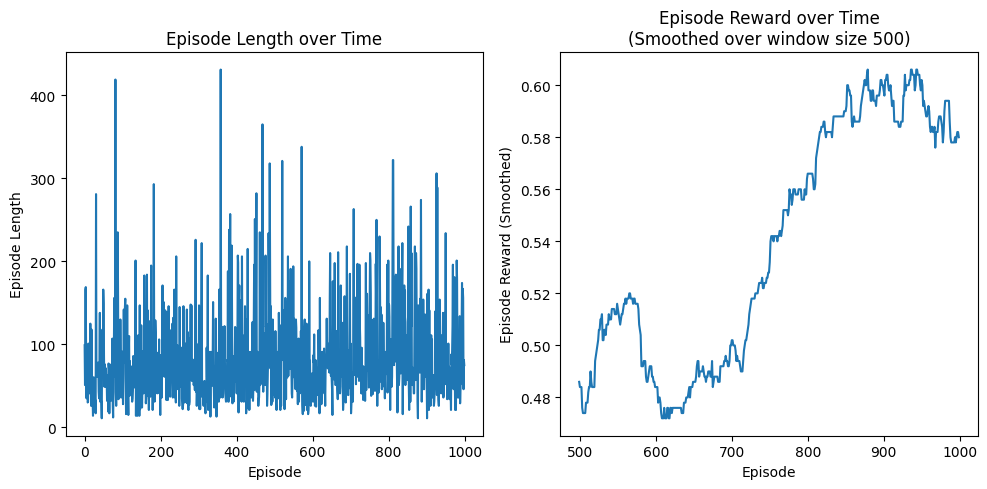

In [7]:
smoothing_window=500
fig, axes = plt.subplots(1, 2, figsize=(10, 5), tight_layout=True)

# Plot the episode length over time
ax = axes[0]
ax.plot(stats.episode_lengths)
ax.set_xlabel("Episode")
ax.set_ylabel("Episode Length")
ax.set_title("Episode Length over Time") 

# Plot the episode reward over time
ax = axes[1]
rewards_smoothed = pd.Series(stats.episode_rewards).rolling(smoothing_window, min_periods=smoothing_window).mean()
ax.plot(rewards_smoothed)
ax.set_xlabel("Episode")
ax.set_ylabel("Episode Reward (Smoothed)")
ax.set_title(f"Episode Reward over Time\n(Smoothed over window size {smoothing_window})")
plt.show()

In [8]:
# smoothing_window=500
# fig, axes = plt.subplots(1, 2, figsize=(10, 5), tight_layout=True)

# # Plot the episode length over time
# ax = axes[0]
# ax.plot(stats.episode_lengths)
# ax.set_xlabel("Episode")
# ax.set_ylabel("Episode Length")
# ax.set_title("Episode Length over Time") 

# # Plot the episode reward over time
# ax = axes[1]
# rewards_smoothed = df["reward"].rolling(smoothing_window, min_periods=smoothing_window).mean()
# ax.plot(rewards_smoothed)
# ax.set_xlabel("Episode")
# ax.set_ylabel("Episode Reward (Smoothed)")
# ax.set_title(f"Episode Reward over Time\n(Smoothed over window size {smoothing_window})")
# plt.show()

In [9]:
df = pd.read_csv("../results/freeway_dqn_stats.csv")

FileNotFoundError: [Errno 2] No such file or directory: '../results/freeway_dqn_stats.csv'

In [5]:
df = pd.DataFrame({
    "episode": range(1, len(stats.episode_lengths) + 1),
    "length": stats.episode_lengths,
    "reward": stats.episode_rewards
})

save_path = "../results/freeeway_per_stats.csv"

df.to_csv(save_path, index=False)

NameError: name 'pd' is not defined

In [6]:
from IPython.display import Image as IImage

def save_rgb_animation(rgb_arrays, filename, duration=50):
    """Save an animated GIF from a list of RGB arrays."""
    # Create a list to hold each frame
    frames = []

    # Convert RGB arrays to PIL Image objects
    for rgb_array in rgb_arrays:
        rgb_array = (rgb_array*255).astype(np.uint8)
        rgb_array = rgb_array.repeat(48, axis=0).repeat(48, axis=1)
        img = Image.fromarray(rgb_array)
        frames.append(img)

    # Save the frames as an animated GIF
    frames[0].save(filename, save_all=True, append_images=frames[1:], duration=duration, loop=0)

def rendered_rollout(policy, env, max_steps=1_000):
    """Rollout for one episode while saving all rendered images."""
    obs, _ = env.reset()
    imgs = [env.render()]

    for _ in range(max_steps):
        action = policy(torch.as_tensor(obs, dtype=torch.float32).unsqueeze(0))
        obs, _, terminated, truncated, _ = env.step(action)
        imgs.append(env.render())
        
        if terminated or truncated:
            break

    return imgs

policy = make_epsilon_greedy_policy(agent.q, num_actions=env.action_space.n)
imgs = rendered_rollout(policy, env)
save_rgb_animation(imgs, "trained.gif")
IImage(filename="trained.gif")

NameError: name 'make_epsilon_greedy_policy' is not defined

We have not trained very far because it can be very time consuming. But feel free to change the hyperparameters and try to improve your results!

---
<span style="color:orange">**EXERCISE**</span>: **The deadly triad** (2 points)

In Sutton and Barto's "Reinforcement Learning: An Introduction" they introduced the concept of the **Deadly Triad**. Investigate this concept and explain in your own words what it describes. What does it say about DQNs?

**Your answers here:**

The Deadly triad consists of three factors: Bootstrapping, Function Approximation, and Off-Policy learning. The three combined have the danger of divergence. With bootstrapping you use the estimated values of next states to update the current state, which can become problematic, as the weights of the network are updated simultaneously for every state with function approximation. When using Off-Policy learning, the agent might learn on actions that the target would take infrequently and when expectations are increased, they can be left unchecked, blowing off and leading to divergence. DQNs use all three. 

In the book it is mentioned that if the behavior policy is sufficiently close to the target, like in the case of epsilon-greedy, Q-learning is not found to diverge. They then discuss using methods of avoiding the deadly triad such as using MC to avoid Bootstrapping or Sarsa to be On-Policy. One can also use Double Q-learning, Target Net

---
<span style="color:orange">**EXERCISE**</span>: **Going beyond discrete action spaces** (1.5 points)

1. What is the difference between discrete and continuous action spaces?
2. Name a key problem that may arise by using DQN for continuous action spaces. Hint: Think about how we select a greedy action.


**Your answers here:**
1. One chooses a discrete action and the other has continous space. Like choosing Left or Right or choosing how much Left or Right.
2. When you take the max over actions, it is easy to for discrete actions as you can enumerate and iterate, which you can't do for the continous case. 

---
<span style="color:orange">**FEEDBACK**</span>

Describe your experience with this exercise and the course. We have set up an anonymous option for this in ILIAS or you can write your feedback directly here in the notebook. Please note that your feedback will help us to improve the course.

I really enjoyed this exercise. It was the right amount of challenge, in my opinion, at least for me. I think a test for the update_dqn function would be a nice addition, as it can fail silently, due to the broadcasting of torch tensors. This was at least the case for me, but luckily the bug was found quickly. 